# GAMMA Case: PowerCo


Majid Mosayebi

Nov 8, 2017

# Project Goals

* Predict the the probability that a given SME churn based on the data 
    
* Asessment of the consequences of a 20%-discount rate offer to users with high propensity to churn

# Table of Contents
* [GAMMA Case: PowerCo](#GAMMA-Case:-PowerCo)
* [Project Goals](#Project-Goals)
* [Utility functions](#Utility-functions)
* [Importing and preprocessing data (parallel implementation)](#Importing-and-preprocessing-data-%28parallel-implementation%29)
* [Classification using XGBoost](#Classification-using-XGBoost)
	* [XGBoost Performance](#XGBoost-Performance)
	* [Varying the threshold, $p_{cut}$](#Varying-the-threshold,-$p_{cut}$)
* [Does the 20%-discount reduce the revenue?](#Does-the-20%-discount-reduce-the-revenue?)
	* [Most important features for classification](#Most-important-features-for-classification)
	* [Relationship between the top 10 most important features.](#Relationship-between-the-top-10-most-important-features.)
		* [Correlation among features](#Correlation-among-features)
* [Re-train the XGBoost on the whole training set and generate the output values for the unknown data](#Re-train-the-XGBoost-on-the-whole-training-set-and-generate-the-output-values-for-the-unknown-data)
* [Visualization of the price history](#Visualization-of-the-price-history)
* [Let's try other classifiers](#Let's-try-other-classifiers)


# Utility functions
Before starting I define a few useful functions. I will use these throughout this notebook.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import random as random
from pprint import pprint
import pickle
from concurrent import futures
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="darkgrid", color_codes=True, font_scale=1.6)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, \
                            precision_score, f1_score, log_loss, roc_curve, auc, brier_score_loss

def plot_hist(x, title='', c='b', label='prediction'): 
    """
    This function plots the histogram of x.
    """
    # the histogram of the data
    plt.rcParams["figure.figsize"] = (6,4)
    n, bins, patches = plt.hist(x, 50, normed=0, facecolor=c, alpha=0.65, label=label)
    plt.xlabel('Prediction')
    plt.ylabel('Frequency')
    plt.xlim((0,1))
    plt.title(title)
    plt.legend()
    plt.grid(True) 
    #plt.show()

    

def plot_roc_curve(y, prediction):
    """
    This function plots the ROC curve.
    """
    plt.rcParams["figure.figsize"] = (6,4)
    sns.set(style="darkgrid", color_codes=True, font_scale=1.6)
    fpr, tpr, _ = roc_curve(y, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    sns.set(style="dark", color_codes=True, font_scale=1.6)
    plt.rcParams["figure.figsize"] = (7,5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    plt.subplot(111)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    plt.show()
   
    
def plot_sns_pairplot(df, features_to_plot, hue='churn'):
    """
    This function plots the sns pair plot of the dataframe, df.
    """
    num_features = len(features_to_plot)
    plt.rcParams['figure.figsize']=(3,3)
    #plt.rcParams["axes.labelsize"] = 14
    sns.set(style="darkgrid", color_codes=True, font_scale=1.6)
    g = sns.pairplot(data=df.sample(len(df)), hue=hue, vars=features_to_plot,  markers=['d','o']) 
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)
    for ax in g.axes.flat: 
        plt.setp(ax.get_xticklabels(), rotation=45)   
        #ax.set_xlabel(ax.get_xlabel(), fontsize=25)
        [i.set_alpha(0.2) for i in ax.lines]
        [i.set_alpha(0.2) for i in ax.collections]
    sns.despine()
    # def corrfunc(x, y, **kws):
    #     from scipy import stats
    #     r, _ = stats.pearsonr(x, y)
    #     ax = plt.gca()
    #     ax.annotate("r = {:.2f}".format(r),
    #                 xy=(.1, .9), xycoords=ax.transAxes)
    # g.map_lower(corrfunc)
    g.fig.suptitle('Relation between the %s most important features. Green symbols : churned'%num_features,
    fontsize=34,color="m",alpha=0.5)
     
    
def generate_stats_from_hist_data_col(params):
    """
    This function generates new statistics columns from the hist_data for the col.
    """
    data, hist_data, col = params
    labels = "mean median max min std sum".split()
    lst = []
    for ind, row in data[:].iterrows():
        hist_frame = hist_data[hist_data.index == ind]
        if len(hist_frame[col])>0 :
            mean = np.mean(hist_frame[col])
            median = np.median(hist_frame[col])
            maxim = np.max(hist_frame[col])
            minim = np.min(hist_frame[col])
            std = np.std(hist_frame[col])
            tot = np.sum(hist_frame[col])
        else:
            mean, median, maxim, minim, std, tot= np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        lst.append([ind, mean,median,maxim,minim,std,tot])
    headers = ['id'] + ["%s_%s"%(p,col) for p in labels]
    my_df = pd.DataFrame(lst, columns=headers)
    my_df.index = my_df.pop('id') 
    print ("stats are generated for column %s."%col)
    return my_df 

def generate_stats_parallel_run(data, hist_data, cols, cores=4):
    """
    This function 
    """
    params_list = [(data, hist_data, col) for col in cols] 
    with futures.ProcessPoolExecutor(max_workers=cores) as executor:
        out = executor.map(generate_stats_from_hist_data_col, params_list)
    data_copy = data.copy()
    for my_df in out:
        data_copy = pd.concat([my_df, data_copy], axis=1)
    return data_copy


def save_obj(obj, name):
    """
    This function pickles an object and saves it to the disk.
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        print ('saved data to \'%s\'.' % (name + '.pkl'))
        
        
def load_obj(name):
    """
    This function loads a pickled object.
    """
    with open(name + '.pkl', 'rb') as f:
        print ('loading from \'%s\' ...' % (name + '.pkl'))
        return pickle.load(f)

# Importing and preprocessing data (a parallel implementation)

1.  Each DATE value is converted to an integer that shows the number of days to today's date.

2.  All categorical data are converted to multiple binary values using the one hot labeling method.

3.  Also, I generated new statistical features from the year 2015 prices and appended them to the data. The new features include mean, median, maximum, minimum, standard deviation and sum of the monthly prices for each SME in the year 2015.

4.  Optionally, I imputed all missing values (except categorical ones that have been dealt with in step 2) to the most frequent value in the column.

5.  The above procedure has been performed on all data combined together. At the end I split the data into train and final_test sets. The `X` (matrix of the feature values) and `y` (vector of the chrun value) are generated for all SMEs in the training set and are going to be fed directly to the classifier(s).

In [2]:
print ('Reading datasets by converting all dates to the number of days to today\'s date, %s'% pd.to_datetime('today'))
date_col_names = ['date_activ','date_end','date_first_activ','date_modif_prod','date_renewal']
dataset1 = pd.read_csv('./data/ml_case_training_data.csv', index_col='id', parse_dates=date_col_names)
dataset2 = pd.read_csv('./data/ml_case_test_data.csv'    , index_col='id', parse_dates=date_col_names) 
data = pd.concat([dataset1,dataset2])
for col in date_col_names: 
    data [col] = ( pd.to_datetime('today') - data[col])  / np.timedelta64(1,'D')

#removing all emty rows and cols
data = data.dropna(how='all', axis=1)
data = data.dropna(how='all', axis=0)

#one hot labeling of the categorical data. 
obj_ = data.select_dtypes(include=['object']).copy()
#adding the label "missing" for all missing values
obj_ = obj_.fillna('missing')
cols = obj_.columns
obj_ = pd.get_dummies(obj_, columns=cols, prefix=cols)
num_ = data.select_dtypes(include=['float64', 'int64']).copy()
data = pd.concat([num_, obj_], axis=1)


read_from_disk = True
generate_stat = True
if (not read_from_disk):
    if (generate_stat):
        # generating hist stat data
        dataset3 = pd.read_csv('./data/ml_case_training_hist_data.csv', index_col='id')
        dataset4 = pd.read_csv('./data/ml_case_test_hist_data.csv'    , index_col='id') 
        hist_data = pd.concat([dataset3, dataset4]).dropna()
        cols = ['price_p1_var','price_p2_var','price_p3_var', 'price_p1_fix',  'price_p2_fix',  'price_p3_fix']
        data = generate_stats_parallel_run(data, hist_data, cols, cores=6)

    #imputing missing values with the most frequent item in the column [OPTIONAL]
    impute_flag='most_frequent' # can be None, 'median' or 'mean'
    if (not impute_flag==None):
        from sklearn import preprocessing
        imp = preprocessing.Imputer(axis=0, copy=True, missing_values='NaN', strategy=impute_flag, verbose=0)
        cols = data.columns
        data[cols] = imp.fit_transform(data[cols]) 
        
    #add the training labels to data
    data['churn'] = pd.read_csv('./data/ml_case_training_output.csv', index_col='id')
    
    # save data    
    save_obj(data, 'data')
    
data = load_obj('data')
data.info()


X_FinalTest  = data[np.isnan(data['churn'])].dropna(how='all', axis=1)
train = data[~np.isnan(data['churn'])]
y = train.pop('churn')
X = train

Reading datasets by converting all dates to the number of days to today's date, 2017-11-08 00:00:00
loading from 'data.pkl' ...
<class 'pandas.core.frame.DataFrame'>
Index: 20120 entries, 48ada52261e7cf58715202705a0451c9 to 9d04b44f8d8be096420da85198b5d1e3
Columns: 525 entries, mean_price_p3_fix to churn
dtypes: float64(525)
memory usage: 80.7+ MB


# Classification using XGBoost
XGBoost is short for eXtreme Gradient Boosting and is the winning model for several kaggle competitions. It's fast and powerful and can handle missing data very well.

-  Splitting the training data into three sets (`X_train`, X_valid, X_test`), I will be able to probe any possible overfitting by looking at the AUC score for the validation set (early stopping criterion). In addition, the `X_test` will provide an unbiased measure for the performance of the model, and therefore helps to tune the hyperparameters of the classifier. 


-  I used a `watchlist` and kept adding more trees to the model until the evaluated AUC score on the validation set has stopped increasing. This was a good point to stop making the model more complicated. Beyond this point the classifier starts to overfit the data.


-  Since the data is highly imbalanced, I have used `max_delta_step=12`. This helps improving the accuracy on the minority group predictions. At the same time it does not ruin the probabilistic interpretation of the final score.

In [4]:
import xgboost as xgb

seed = 2 #random.randint(1,100)
test_size = 0.12
Xtt, X_test, ytt, y_test, ind_tt, ind_test = \
train_test_split(X, y, range(len(y)), test_size=test_size, random_state=seed) 
valid_size  = 0.15
X_train, X_valid, y_train, y_valid, ind_train, ind_valid = \
train_test_split(Xtt, ytt, ind_tt, test_size=valid_size, random_state=seed)  
print ("Size of the {training+validation+test} sets = { %s+%s+%s } = %s\n" % (
       X_train.shape, X_valid.shape, X_test.shape,  X.shape))

dtrain  = xgb.DMatrix(X_train, label = y_train)    
dvalid  = xgb.DMatrix(X_valid, label = y_valid) 
    
param = {'max_depth':8, 'eta':0.01, 'silent':1, 'objective':'binary:logistic', 
         'eval_metric':'auc', 'subsample': 0.65, 'colsample_bytree':0.75, 'nthread':-1, 
         'max_delta_step':12} #,'scale_pos_weight':10, 'gamma':1, 'lambda':1, 'alpha':2}

watchlist  = [(dtrain,'train'), (dvalid,'eval')]
clf = xgb.train(params=param, num_boost_round=100000, \
                verbose_eval=500, dtrain=dtrain,  evals=watchlist, early_stopping_rounds=200)

bst = clf
dtest = xgb.DMatrix(X_test, label = y_test) 
prediction = clf.predict(dtest)

Size of the {training+validation+test} sets = { (12039, 524)+(2125, 524)+(1932, 524) } = (16096, 524)

[0]	train-auc:0.657582	eval-auc:0.627977
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[500]	train-auc:0.960431	eval-auc:0.719691
Stopping. Best iteration:
[435]	train-auc:0.949443	eval-auc:0.720122



## XGBoost Performance

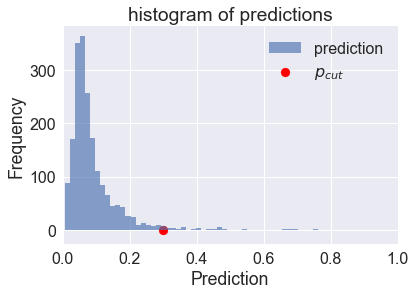

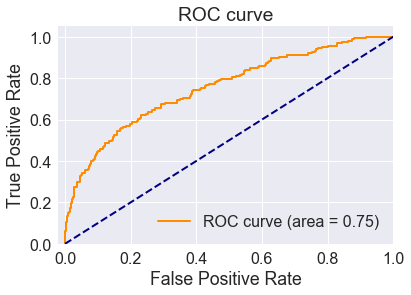

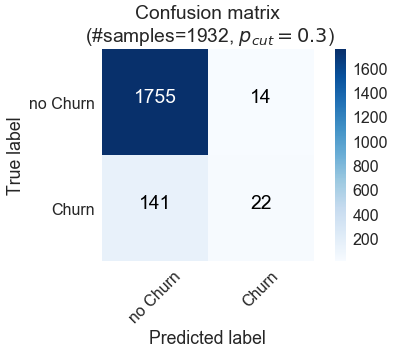

P: Churn & N: No Churn
Accuracy [(TP+TN)/(TP+TN+FP+FN)]: 91.98%
Recall [TP/(TP+FN)]: 13.50%
Pricision [TP/(TP+FP)] : 61.11%
f1_score : 0.22
Brier_score : 0.08



In [11]:
p_cut = 0.3
#plot_hist(y_valid, title='histogram of predictions/target', c='g', label='target')
plot_hist(prediction, title='histogram of predictions', c='b', label='prediction')
plt.scatter(p_cut,0, s=80, c='red', label='$p_{cut}$')
plt.legend()

plot_roc_curve(y_test, prediction)

yy = y_test
accuracy = accuracy_score(yy, prediction>p_cut) * 100
precision = precision_score(yy, prediction>p_cut) * 100
recall = recall_score(yy, prediction>p_cut)* 100
f1 = f1_score(yy, prediction>p_cut)
brier = brier_score_loss(yy, prediction>p_cut)

cm = confusion_matrix(y_test, prediction>p_cut)

plot_confusion_matrix(cm, ['no Churn', 'Churn'],
                          normalize=False,
                          title='Confusion matrix\n (#samples=%s, $p_{cut}=%s$)'%(len(prediction), p_cut),
                          cmap=plt.cm.Blues)

print ("P: Churn & N: No Churn")
print  ("Accuracy [(TP+TN)/(TP+TN+FP+FN)]: %.2f%%\nRecall [TP/(TP+FN)]: %.2f%%\nPricision [TP/(TP+FP)] : %0.2f%%\nf1_score : %.2f\nBrier_score : %.2f\n" \
       %(accuracy, recall, precision, f1, brier)) 

## Varying the threshold, $p_{cut}$

The threshold can be varied to get a more (or less) generous prediction of the positive (churn) class. I chose  pcut=0.3pcut=0.3 . A choice that doesn't reduce the Precision significantly, and at the same time gives good values for the Brier and  $f1$ scores.

The AUC score doesn't depend on the  pcutpcut  and is ~0.75.

# Does the 20%-discount reduce the revenue?

Let's look again at the performance measures of the classifier. we obtained the following scores

*  Accuracy <font color=grey>[ (TP+TN)/(TP+TN+FP+FN) ]</font>: 91.98% 
*  Recall <font color=grey>[ TP/(TP+FN) ]</font>: 13.50%
*  Pricision <font color=grey>[ TP/(TP+FP) ]</font>: 61.11%
*  Brier_score : 0.08

Assumptions: 
*  All customers who are offered the 20% discount will accept it
*  The price cannot be raised within a year

Because the `Precision` score of the classification is around 60%, therefore the steep discount of 20% does not decrease the revenue. 

The revenue would have decreased only if the the precision would be below the discount rate.

## Most important features for classification

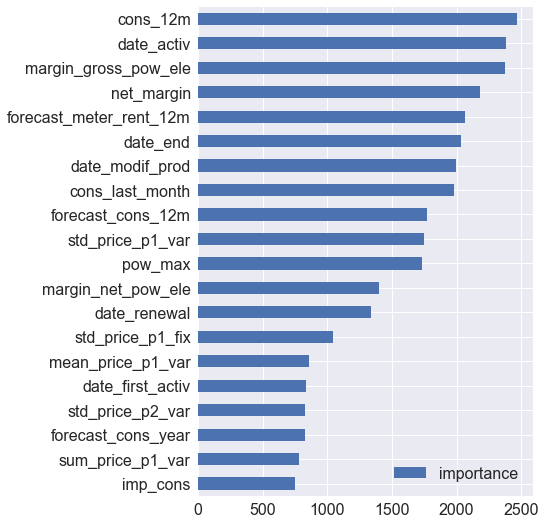

In [6]:
importance = pd.DataFrame.from_dict(clf.get_fscore(), orient='index')
importance.columns=[['importance']]
importance = importance.sort_values('importance', ascending=False)
plt.rcParams["figure.figsize"] = (6,9)
sns.set(style="darkgrid", color_codes=True, font_scale=1.6)
importance[:20].sort_values('importance', ascending=True).plot(kind='barh').legend(loc=4)

## Relationship between the top 10 most important features.

Green symbols show customers who churn. The diagonal plots show the histogram of each feature.

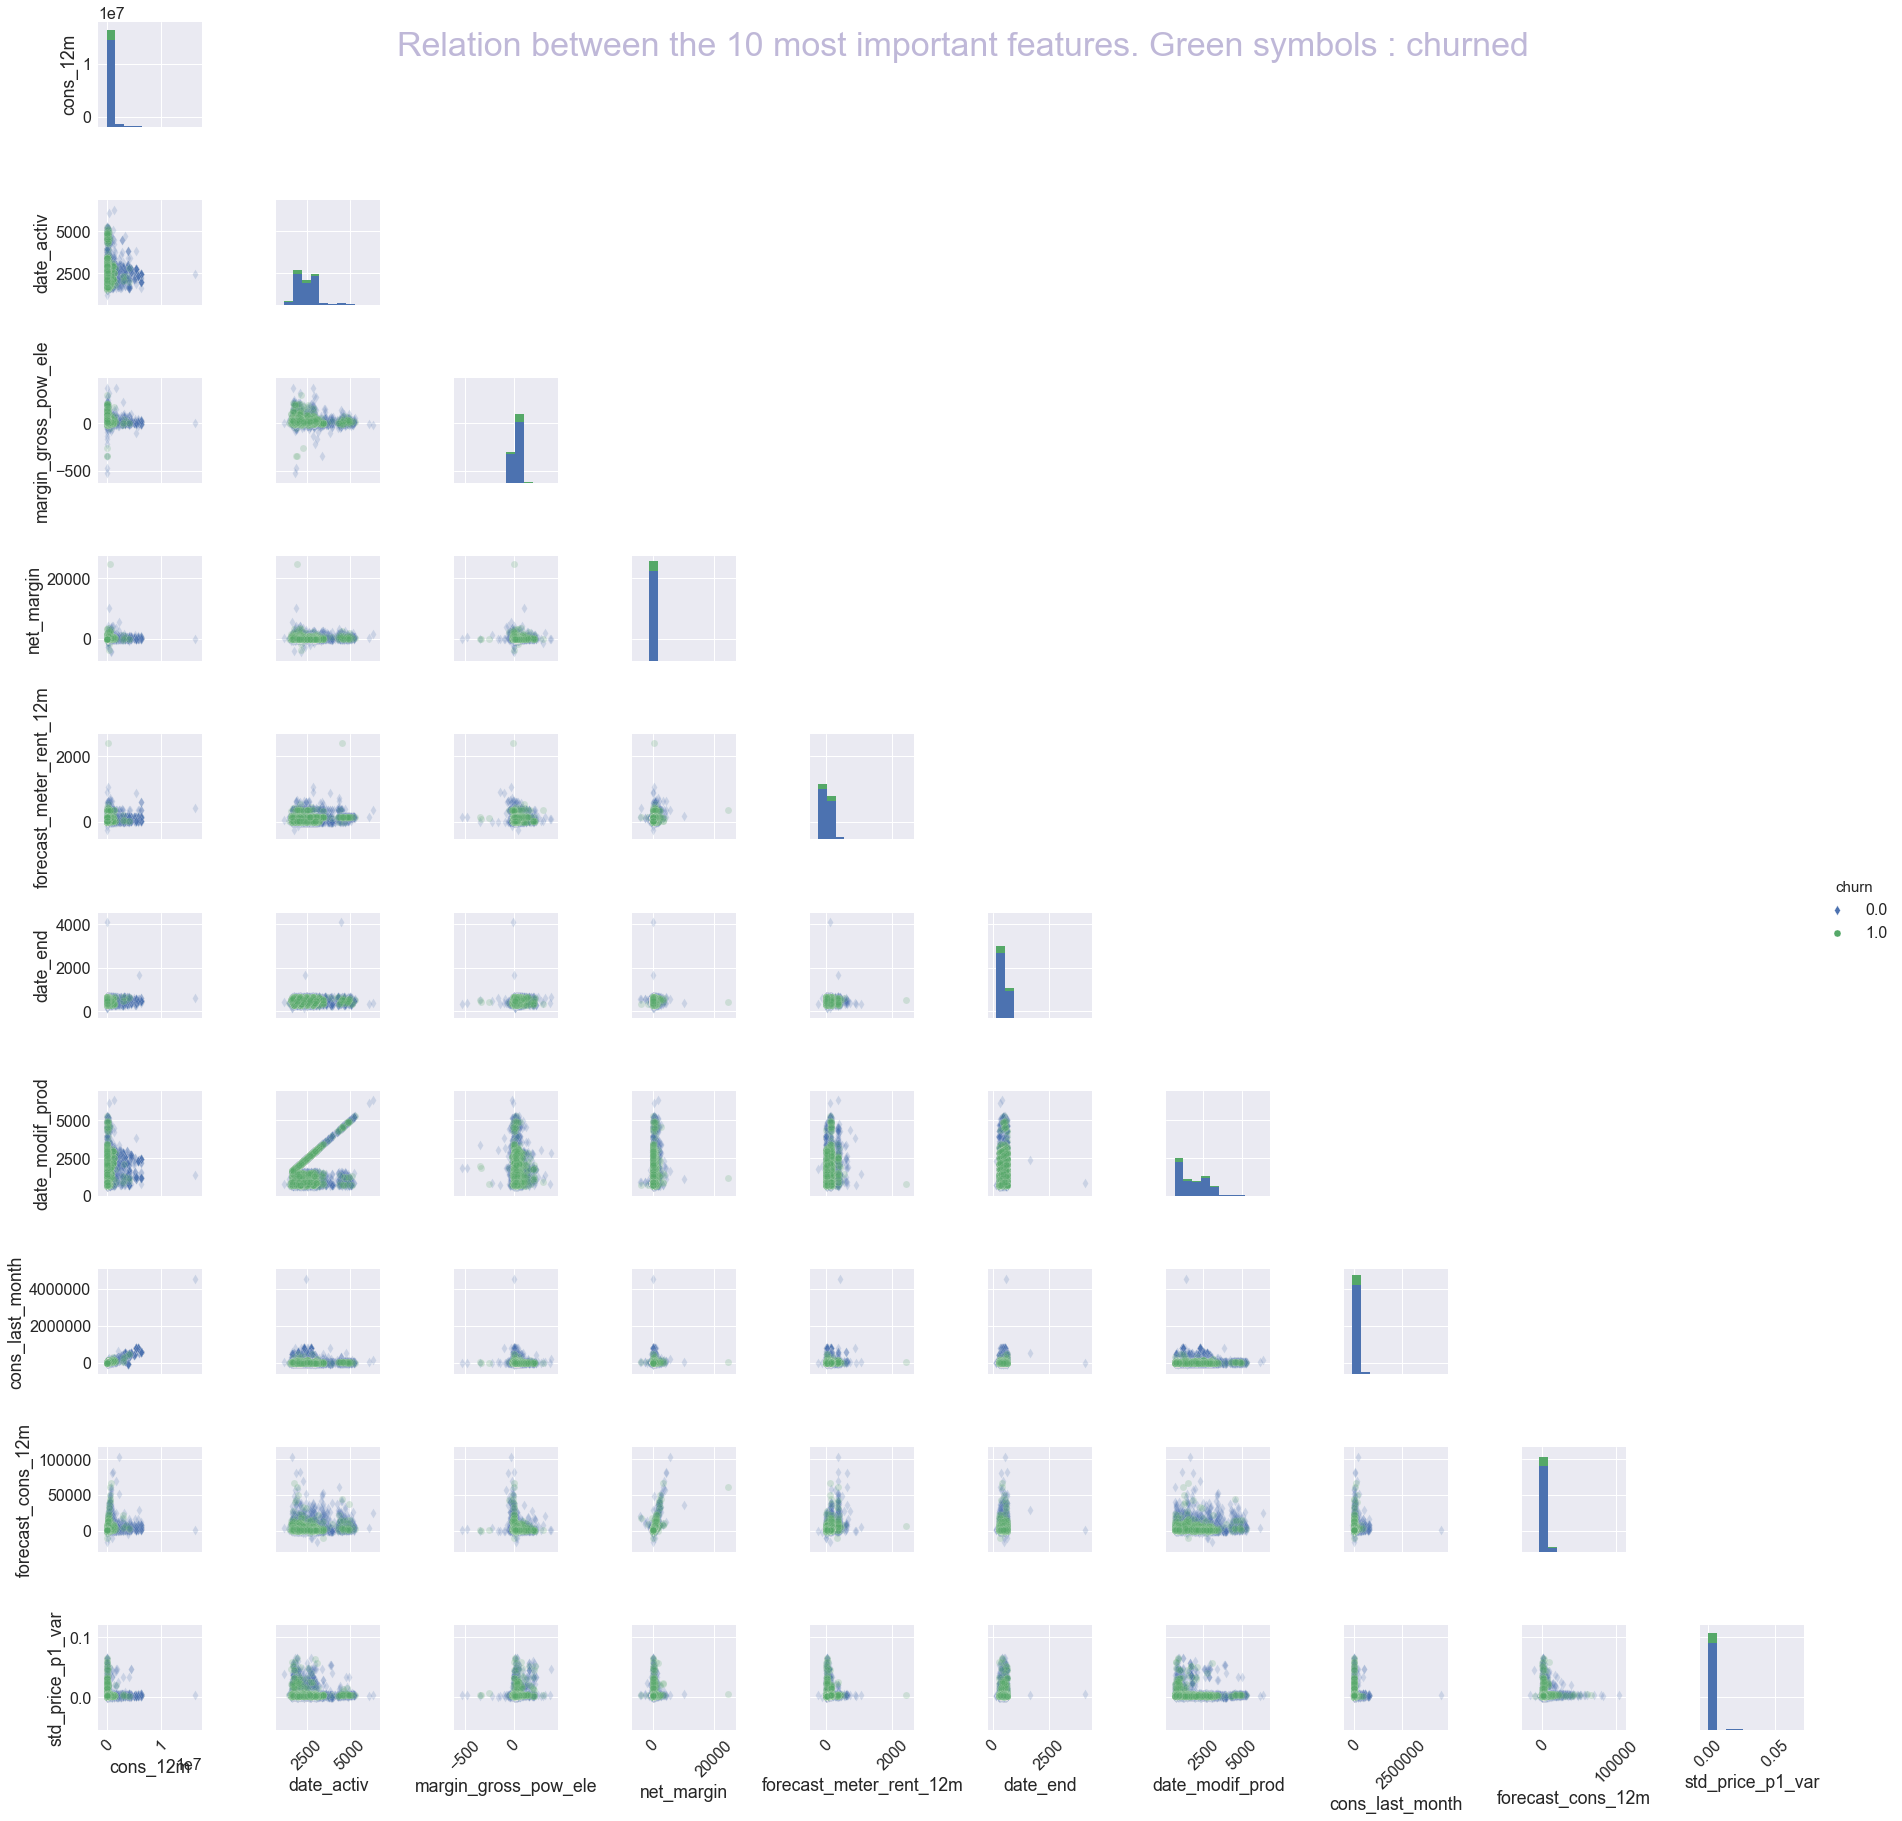

In [7]:
num_features=10
features_to_plot = importance.index[:num_features]
df = pd.concat([y, train[features_to_plot]], axis=1).dropna()
plot_sns_pairplot(df=df, features_to_plot=features_to_plot, hue='churn')

### Correlation among features

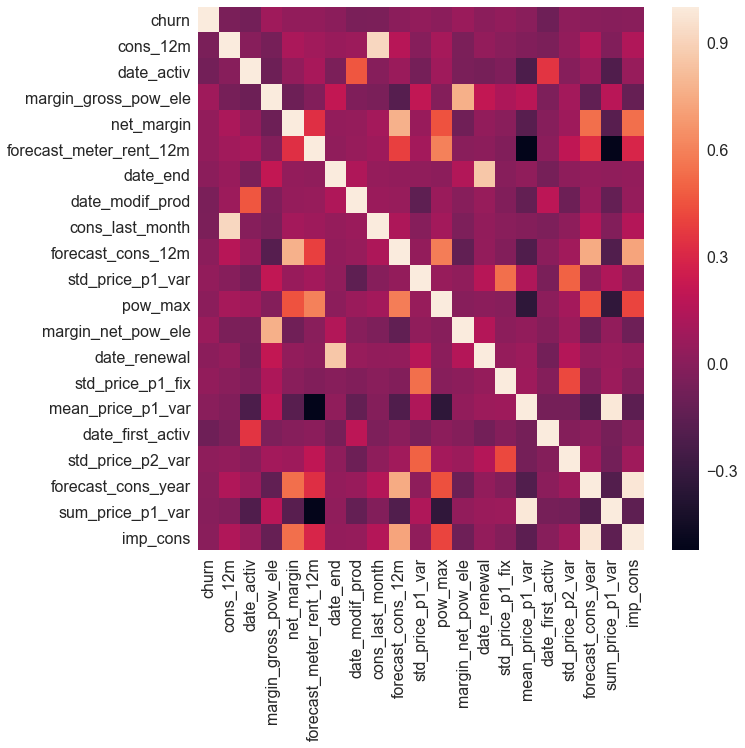

In [8]:
num_features=20
plt.rcParams['figure.figsize']=(10,10)
features_to_plot = importance.index[0:num_features]
df = pd.concat([y, train[features_to_plot]], axis=1).dropna()
corr = df.corr()
g = sns.heatmap(corr)

# Re-train the XGBoost on the whole training set and generate the output values for the unknown data

Here, I used the same set of hyperameters which where tuned earlier.

In [13]:
import xgboost as xgb
dtrain = xgb.DMatrix(X, label = y) 
param = {'max_depth':8, 'eta':0.01, 'silent':1, 'objective':'binary:logistic', 
         'eval_metric':'auc', 'subsample': 0.65, 'colsample_bytree':0.75, 'nthread':-1, 
         'max_delta_step':12}


clf_final = xgb.train(params=param, num_boost_round=435, verbose_eval=500, dtrain=dtrain)
out = X_FinalTest
dtest  = xgb.DMatrix(X_FinalTest)

out = X_FinalTest.copy()
dtest  = xgb.DMatrix(X_FinalTest)
p_cut = 0.3
out['Churn_probability'] = clf_final.predict(dtest)
out['Churn_prediction'] = np.where(out['Churn_probability']>=p_cut, 1, 0)
out = out [['Churn_prediction', 'Churn_probability']].sort_values('Churn_probability', ascending=False)
out.insert(0, '#', range(1,1+len(out)))
ind = out.index
out = out.set_index('#')
out.insert(0,'id', ind)
out.to_csv('ml_case_test_output_mosayebi.csv', index_label=' ')
out.head()

,id,Churn_prediction,Churn_probability
#,,,
1,25ac33d516bc673cad5bdc234661bcda,1,0.798296
2,af746cde31bc82e7262c592a85e0adf7,1,0.796021
3,12fefd499e20260b723fa88b424953ad,1,0.702818
4,8334025685220191a23783470d9446ce,1,0.682466
5,0f68ed0b282ba311b746574652053b22,1,0.650948


# Visualization of the price history

standard deviation of the price is considered.

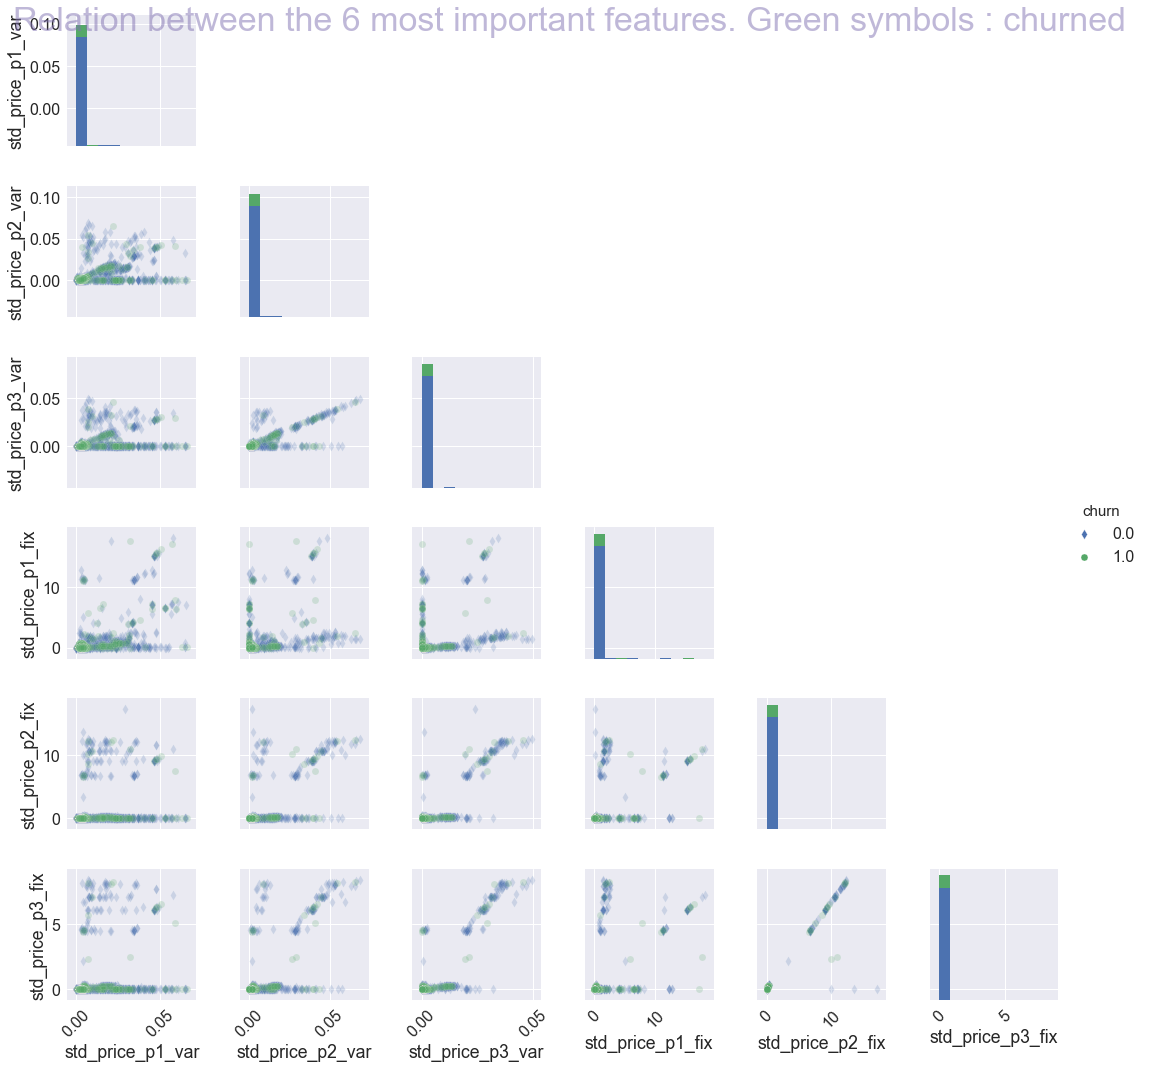

In [10]:
features_to_plot = ['price_p1_var','price_p2_var','price_p3_var', 'price_p1_fix',  'price_p2_fix',  'price_p3_fix']
features_to_plot = ["%s_%s"%('std',col) for col in features_to_plot]
df = pd.concat([y, train[features_to_plot]], axis=1).dropna()
plot_sns_pairplot(df=df, features_to_plot=features_to_plot, hue='churn')

# Let's try other classifiers

I tried the following models. 

1. Random Forest
2. Single Decision Tree

I have tested both algorithms using their default hyperparameters and obtained poor `AUC` scores below 0.6. For the `XGBoost` we had `AUS~0.75`, and hence,  `XGBoost` performed better compared to both models above.

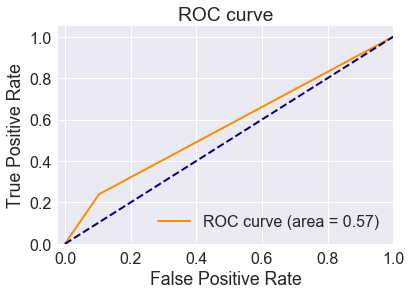

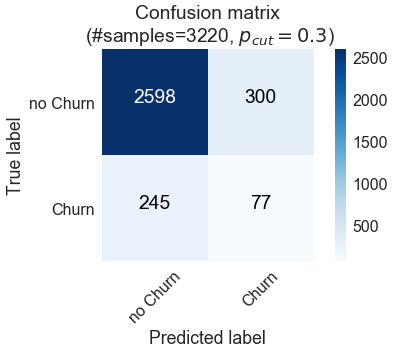

P: Churn & N: No Churn
Accuracy [(TP+TN)/(TP+TN+FP+FN)]: 83.07%
Recall [TP/(TP+FN)]: 23.91%
Pricision [TP/(TP+FP)] : 20.42%
f1_score : 0.22
Brier_score : 0.17



In [67]:
test_size = 0.2
seed=1
X_train, X_test, y_train, y_test, ind_train, ind_test = \
train_test_split(X, y, range(len(y)), test_size=test_size, random_state=seed)

# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=None, max_features='auto', max_leaf_nodes=None,
#             min_impurity_split=1e-07, min_samples_leaf=1,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
#             verbose=0, warm_start=False)
# clf.fit(X_train, y_train)
# prediction = clf.predict(X_test)

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
tree.export_graphviz(clf, out_file='tree.dot') 
p_cut = 0.3
#plot_hist(y_valid, title='histogram of predictions/target', c='g', label='target')
#plot_hist(prediction, title='histogram of predictions', c='b', label='prediction')
#plt.scatter(p_cut,0, s=80, c='red', label='$p_{cut}$')
#plt.legend()

plot_roc_curve(y_test, prediction)

yy = y_test
accuracy = accuracy_score(yy, prediction>p_cut) * 100
precision = precision_score(yy, prediction>p_cut) * 100
recall = recall_score(yy, prediction>p_cut)* 100
f1 = f1_score(yy, prediction>p_cut)
brier = brier_score_loss(yy, prediction>p_cut)
cm = confusion_matrix(y_test, prediction>p_cut)

plot_confusion_matrix(cm, ['no Churn', 'Churn'],
                          normalize=False,
                          title='Confusion matrix\n (#samples=%s, $p_{cut}=%s$)'%(len(prediction), p_cut),
                          cmap=plt.cm.Blues)

print ("P: Churn & N: No Churn")
print  ("Accuracy [(TP+TN)/(TP+TN+FP+FN)]: %.2f%%\nRecall [TP/(TP+FN)]: %.2f%%\nPricision [TP/(TP+FP)] : %0.2f%%\nf1_score : %.2f\nBrier_score : %.2f\n" \
       %(accuracy, recall, precision, f1, brier)) 